# Analysis & *.h5 saving of cells and backgrounds
### Johanna Rahm, Sebastian Malkusch
#### Research group Heilemann
#### Institute for Physical and Theoretical Chemistry, Goethe University Frankfurt a.M.
This notebook as to be reloaded before analysing a new group of data!

## Load *.trc files

Choose/insert a directory for the cell files to be searched in (e.g. F:\Marburg\single_colour_tracking\resting). All *.trc  files in the directory will be loaded for the analysis. It is possible to ignore files, by choosing mask words. If a file name containes any mask word, it will not be loaded. Comma separate multiple mask words (e.g. hmm, background, cell02).

In [1]:
from pySPT.widgets.widgetNotebooks import init_save_track_analysis
from pySPT.widgets import hdf5
from pySPT.widgets import widgetTrackAnalysis
from pySPT.analysis import coverSlip
from pySPT.analysis import trackAnalysis
from tqdm import tqdm_notebook as tqdm
import warnings
widget_track_analysis = widgetTrackAnalysis.WidgetTrackAnalysis()
track_analysis = trackAnalysis.TrackAnalysis()
cover_slip = coverSlip.CoverSlip()
display(widget_track_analysis.ignore_words_box, widget_track_analysis.dir_box, widget_track_analysis.dir_button)
widget_track_analysis.dir_button.on_click(widget_track_analysis.open_dir)
widget_track_analysis.dir_box.observe(widget_track_analysis.change_dir_box)

Text(value='hmm', description='Mask words', placeholder='Type something', style=DescriptionStyle(description_w…

Text(value='directory to be searched in', description='directory', placeholder='Type something', style=Descrip…

Button(description='browse', style=ButtonStyle(), tooltip='browse for directory')

Choose/insert the complete directory for the roi.log file which contains the cell sizes (e.g. F:\Marburg\single_colour_tracking\resting\roi.log). If no cell size was determined, the camera chip size will be set as the size.

In [2]:
display(widget_track_analysis.roi_box, widget_track_analysis.roi_button)
widget_track_analysis.roi_button.on_click(widget_track_analysis.open_roi)
widget_track_analysis.roi_box.observe(widget_track_analysis.change_roi_box)

Text(value='path of roi', description='roi', placeholder='Type something', style=DescriptionStyle(description_…

Button(description='browse', style=ButtonStyle(), tooltip='browse for roi')

## Camera details

Based on the pixel size, the localization will be transfered from pixel to micrometer.
Based on the amount of pixel, the camera area will be calculated (e.g. 256 * 256=65536 pixel). Camera integration time is needed for MSD calculations.

In [3]:
display(widget_track_analysis.camera_pixel_size_box, widget_track_analysis.camera_pixel_amount_box, widget_track_analysis.camera_integration_time_box)

Text(value='158', description='Pixel size [nm]', placeholder='Type something', style=DescriptionStyle(descript…

Text(value='65536', description='Amount of pixel on the camera', placeholder='Type something', style=Descripti…

Text(value='0.02', description='Camera integration time [s]', placeholder='Type something', style=DescriptionS…

## Parameters for Analysis

The degree of freedom of the diffusion coefficient D are inserted in the calculation of D (1D = 2, 2D = 4, 3D = 6 dof). The minimal detectable diffusion coefficient is the threshold for the immobile type analysis.
Based on the formular min_track_length * camera_integration_time = n -> tau_threshold = 0.3*n, the tau threshold for diffusion type determination free & confined is set.

In [4]:
display(widget_track_analysis.points_D_fit_box, widget_track_analysis.dof_box, widget_track_analysis.D_min_box, widget_track_analysis.min_track_length_box)

Text(value='4', description='Number of points fitted for D', placeholder='Type something', style=DescriptionSt…

Text(value='4', description='degree of freedom of D', placeholder='Type something', style=DescriptionStyle(des…

Text(value='0.0065', description='Minimal detectable D  [μm²/s]', placeholder='Type something', style=Descript…

Text(value='20', description='Min track length', placeholder='Type something', style=DescriptionStyle(descript…

The diffusion type analysis can be based on the track id or seg id of the trc file. A track can contain multiple segmentations with different diffusion models that will be averaged. Therefore running the analysis on a segment level is recommended. For PALMTracer .trc files no seg id is available and the track id has to be chosen.

In [5]:
display(widget_track_analysis.trajectory_id_button)

RadioButtons(options=('seg id', 'track id'), value='seg id')

## Run Analysis

In [6]:
warnings.filterwarnings('ignore')
display(widget_track_analysis.run_button)
def run_analysis(event):
    widget_track_analysis.create_clear_output()
    widget_track_analysis.searchSubFolders(widget_track_analysis.dir_name)
    if widget_track_analysis.got_dir:
        cover_slip.tau_threshold_min_length, cover_slip.dt, cover_slip.pixel_size, cover_slip.pixel_amount, cover_slip.dof, cover_slip.D_min, cover_slip.roi_file, cover_slip.cell_files, cover_slip.points_fit_D, cover_slip.seg_id = widget_track_analysis.min_track_length_box.value, widget_track_analysis.camera_integration_time_box.value, widget_track_analysis.camera_pixel_size_box.value, widget_track_analysis.camera_pixel_amount_box.value, widget_track_analysis.dof_box.value, widget_track_analysis.D_min_box.value, widget_track_analysis.roi_name, widget_track_analysis.file_names, widget_track_analysis.points_D_fit_box.value, widget_track_analysis.trajectory_id_button.value      
        cover_slip.create_cells()  
        track_analysis.cell_sizes = [cell.size for cell in cover_slip.cells]
        track_analysis.cell_trajectories = cover_slip.cell_trajectories
        track_analysis.run_statistics_no_filter()
    else:
        widget_track_analysis.warning_trc_file()
    widget_track_analysis.cells = cover_slip.cells
widget_track_analysis.run_button.on_click(run_analysis)


Analysis took 6.029749155044556 s
22.6 % are immobile
23.2 % are confined
47.7 % are free
Total trajectories: 155


## Plot diffusion histogram

Plot the normalized frequency in % against the diffusion coefficients (semi log scale). Diffusion coefficients <= 0 are neglected, because the logarithm is not defined in this interval.

In [7]:
display(widget_track_analysis.bin_size_box)

Text(value='0.1', description='bin size', placeholder='size for log10(D) histogram', style=DescriptionStyle(de…

Button(description='plot', style=ButtonStyle(), tooltip='plot diffusion histogram')

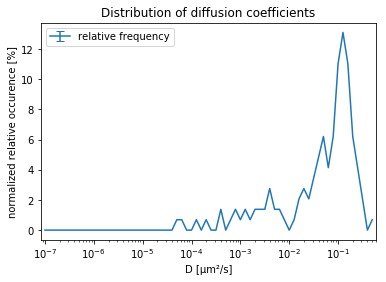

In [8]:
def plot_diffusions(event):
    widget_track_analysis.create_clear_output()
    display(widget_track_analysis.plot_diff_button)
    track_analysis.run_plot_diffusion_histogram(widget_track_analysis.bin_size_box.value)
display(widget_track_analysis.plot_diff_button)
widget_track_analysis.plot_diff_button.on_click(plot_diffusions)

## Choose trajectory to plot

Choose a cell. If one wants to plot multiple times, choose a new cell and/or trajectory reload the plotting cell by clicking in the cell and pressing strg+enter.

In [9]:
def dropdown(event):
    widget_track_analysis.cell_options = widget_track_analysis.get_cell_names(cover_slip.cells)
widget_track_analysis.run_button.on_click(dropdown)
display(widget_track_analysis.drop_down_cells)

Dropdown(description='Number:', options=(), value=None)

Choose a trajectory.

In [10]:
def dropdown(event):      
    for cell in cover_slip.cells:
        if cell.name == widget_track_analysis.drop_down_cells.value:
            target_cell = cover_slip.cells.index(cell)
            trajectory_indexes = [i+1 for i, _ in enumerate(cover_slip.cell_trajectories[target_cell])]
            widget_track_analysis.trajectory_options = trajectory_indexes
            widget_track_analysis.drop_down_trajectories.options = widget_track_analysis.trajectory_options
widget_track_analysis.drop_down_cells.observe(dropdown)
display(widget_track_analysis.drop_down_trajectories)

Dropdown(description='Number:', options=(), value=None)

Button(description='plot', style=ButtonStyle(), tooltip='plot chosen trajectory')

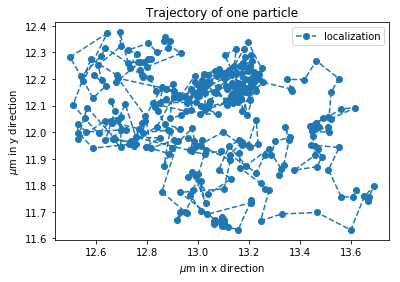

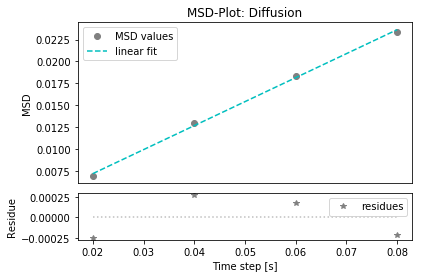

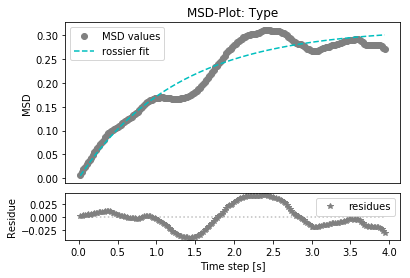

Number: 19
Trajectory length: 330
Diffusion coefficient: 0.06823753641457811 μm²/s
MSD0: 0.0017849644003040798 μm²
chi² linear fit: 1.7727281221329374e-05 μm⁴
Type immobile: False
Analyse successful? True
chi² rossier fit: 0.4252155509946751 μm⁴
Type confined: False
Type free: True
D_conf: 0.062050686173833844 μm²/s
r_conf: 0.486050360643286 μm
tau: 1.2690966458164674 s
tau threshold: 0.12 s


In [11]:
def plot_particle(event):
    widget_track_analysis.create_clear_output()
    display(widget_track_analysis.plot_button)
    cover_slip.plot_trajectory(widget_track_analysis.drop_down_cells.value, widget_track_analysis.drop_down_trajectories.value)
display(widget_track_analysis.plot_button)
widget_track_analysis.plot_button.on_click(plot_particle)

## Save

For each cell a .h5 file will be created, containing all information of the trajectories (unfiltered).

In [12]:
def save_analysis(event):    
    for cell_index in tqdm(range(0, len(cover_slip.cells))):
        init_save_track_analysis(cover_slip, cell_index, track_analysis, widget_track_analysis.points_D_fit_box.value)
display(widget_track_analysis.save_button)
widget_track_analysis.save_button.on_click(save_analysis)

Button(description='save', style=ButtonStyle(), tooltip='save entire analysis')